Required Libraries

In [ ]:
!pip install tensorflow

^C


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


### Data Extraction

In [ ]:
path = 'C:\\Users\\k213084\\Desktop\\COVID-19_Radiography_Dataset'

In [ ]:
df_n = pd.read_excel(path+'/Normal.metadata.xlsx')

In [ ]:
df_n.head()
# We've paths of every image in the COVID

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
# Now we're selecting the covid and normal folder we can also choose other but right now we're working on the
# COVID and Normal

Imbalanced Dataset

In [ ]:
len(os.listdir(path+'/COVID/'))
# We've two folders inside the COVID folder

2

In [ ]:
len(os.listdir(path+'/COVID/images/'))
# no. of images we've in the covid folder

3616

In [ ]:
len(os.listdir(path+'/Normal/'))
# We've two folders inside the Normal folder

2

In [ ]:
len(os.listdir(path+'/Normal/images/'))
# no. of images

10192

In [ ]:
# we detected the problem here that training data is not balanced right now
# Imbalanced dataset usually have low accuracy or biased data

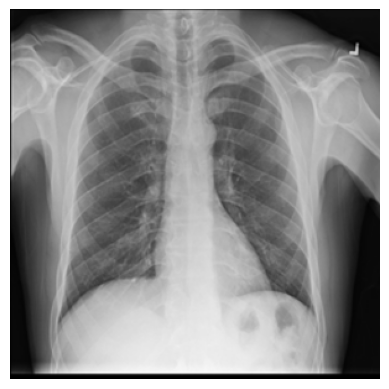

In [ ]:
# Reading any one image using cv2
img = cv2.imread(path+'/Normal/images/Normal-10074.png')
sns.set(style="white")
plt.axis('off')
plt.imshow(img)

In [ ]:
# dimension of the image
print('Image Shape: {}'.format(img.shape))
print('Image Height: {}'.format(img.shape[0]))
print('Image Width: {}'.format(img.shape[1]))
print('Image Dimension: {}'.format(img.ndim))
print('Image Size: {}kb'.format(img.size//1024))
print('Image Data Type: {}'.format(img.dtype))
print('Maximum RGB value of the image: {}'.format(img.max()))
print('Minimum RGB value of the image: {}'.format(img.min()))
# We don't want to resize the images because all the images in the dataset is 299*299 pixels mentioned
# in the description at kaggle where the datset is located

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 0


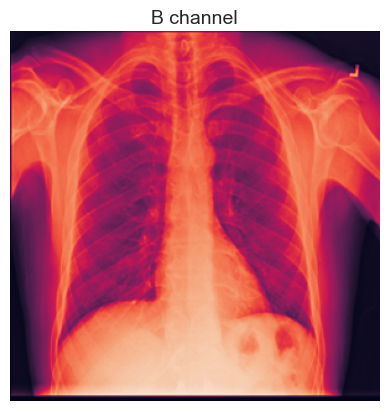

In [ ]:
# We also observe that the image has 3 channels, hence it in in RGB scale even if these are X-ray images.
plt.title('B channel', fontsize = 14)
plt.imshow(img[ : , : , 0])
plt.axis('off')
plt.show()

Different Types of Augmentation

In [ ]:
chosen_image = cv2.imread(path+"/COVID/images/COVID-1002.png")

albumentation_list = [A.RandomFog(p = 1), A.RandomBrightness(p = 1),
                      A.RandomCrop(p = 1,height = 199, width = 199), A.Rotate(p = 1, limit = 90),
                      A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomContrast(limit = 0.5, p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)

titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    img = img / 255.0
    #print(img_path)
    # if we want to resize the images
    img = cv2.resize(img, (100, 100)) # runtime crashing again and again
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels

In [ ]:
covid_path = path+"/COVID/images"
covidUrl = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrl, 1) # 1 is -ve class

In [ ]:
len(covidUrl), len(covidImages)

(3616, 3616)

In [ ]:
normal_path = path+"/Normal/images"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0) # 0 is +ve class

In [ ]:
len(normal_urls), len(normalImages)

(10192, 10192)

In [ ]:
# returning a list so I cannot use as an array so we've to typecast it into array
# Why? because we cannot directly reshape the data, we cannot divide the data by 255 to normalize the images

# covidImages = np.asarray(covidImages)
# normalImages = np.asarray(normalImages)

In [ ]:
covidImages.shape

(3616, 100, 100, 3)

In [ ]:
normalImages.shape

(10192, 100, 100, 3)

In [ ]:
# Concatenating the data row wise
data = np.r_[covidImages, normalImages]
targets = np.r_[covidTargets, normalTargets]

In [ ]:
data.shape

(13808, 100, 100, 3)

In [ ]:
targets.shape

(13808,)

In [ ]:
# data = data/255.0
# failed to do this because I don't have much RAM because data is too large
# runtime disconnected
# 1st solution is resizing the image
# Second solution is Keras. It fetches the data in bathces we don't even have to write code

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(data, targets, test_size=0.2, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Configuring Tensorflow to avoid deprecation warnings
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


# Your model definition
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])


C:\Users\k213084\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 23, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 16)        2320      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 10, 10, 16)       

In [ ]:

# Model compilation
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])



In [ ]:
# Model training with explicit validation data
cnn_model=model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
346/346 [==============================] - 14s 42ms/step - loss: 0.0249 - accuracy: 0.9919 - val_loss: 0.1839 - val_accuracy: 0.9580
Epoch 2/10
346/346 [==============================] - 14s 41ms/step - loss: 0.0125 - accuracy: 0.9962 - val_loss: 0.2265 - val_accuracy: 0.9442
Epoch 3/10
346/346 [==============================] - 15s 42ms/step - loss: 0.0171 - accuracy: 0.9941 - val_loss: 0.2123 - val_accuracy: 0.9500
Epoch 4/10
346/346 [==============================] - 15s 42ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.2632 - val_accuracy: 0.9544
Epoch 5/10
346/346 [==============================] - 14s 42ms/step - loss: 0.0060 - accuracy: 0.9977 - val_loss: 0.3248 - val_accuracy: 0.9544
Epoch 6/10
346/346 [==============================] - 14s 41ms/step - loss: 0.0135 - accuracy: 0.9951 - val_loss: 0.3210 - val_accuracy: 0.9421
Epoch 7/10
346/346 [==============================] - 14s 42ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.3176 - val_accuracy:

### Evaluation

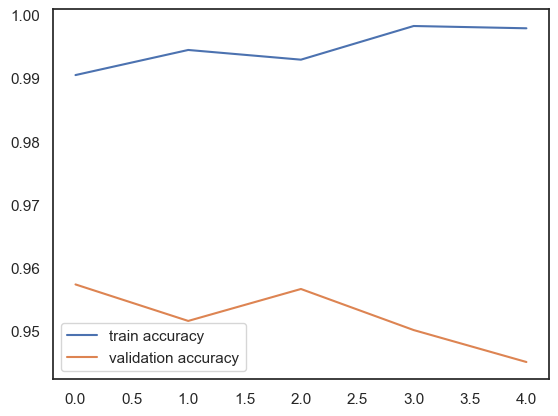

In [ ]:
plt.plot(cnn_model.history['accuracy'], label = 'train accuracy')
plt.plot(cnn_model.history['val_accuracy'],label = 'validation accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


44/44 [==============================] - 1s 12ms/step - loss: 0.2535 - accuracy: 0.9522
Test Loss: 0.2535429000854492, Test Accuracy: 0.9522085189819336


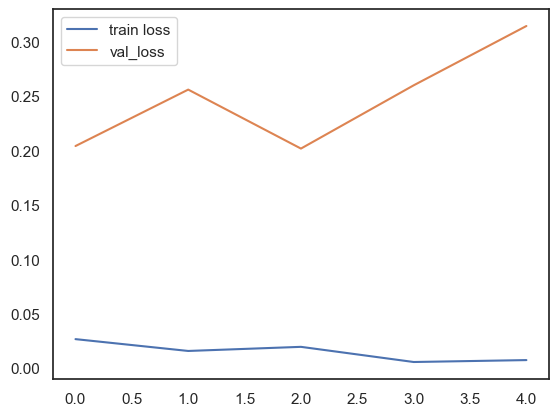

In [ ]:
plt.plot(cnn_model.history['loss'], label = 'train loss')
plt.plot(cnn_model.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
yp_train = model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

44/44 [==============================] - 1s 12ms/step


In [ ]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):

    print("\n-----------------------------{}-----------------------------\n".format(name))

    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)

    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train))
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")

    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)

    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val, zero),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)

    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)

    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")

    t1.plot()
    t2.plot()
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      8162
           1       0.00      0.00      0.00      2884

    accuracy                           0.74     11046
   macro avg       0.37      0.50      0.42     11046
weighted avg       0.55      0.74      0.63     11046

--------------------------------------------------------------------------
Recall on Train Data:  0.0
Specificity on Train Data:  1.0
Accuracy on Train Data:  0.7389
Precision on Train Data:  0.0
F1 Score on Train Data:  0.0
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1001
           1       0.00      0.00      0.00       380

    accuracy                           0

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           0       0.75      1.00      0.85      1029
           1       0.00      0.00      0.00       352

    accuracy                           0.75      1381
   macro avg       0.37      0.50      0.43      1381
weighted avg       0.56      0.75      0.64      1381

--------------------------------------------------------------------------
Recall on Test Data:  0.0
Specificity on Test Data:  1.0
Accuracy on Test Data:  0.7451
Precision on Test Data:  0.0
F1 Score Test Data:  0.0
--------------------------------------------------------------------------


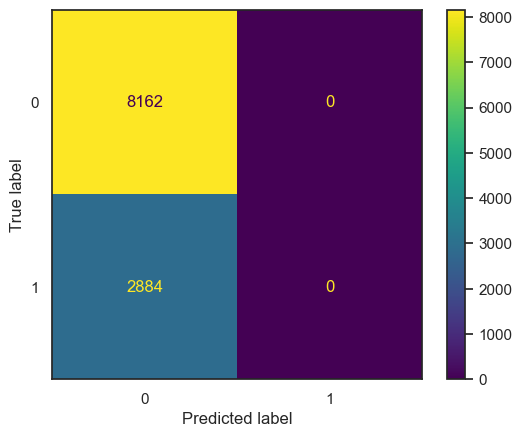

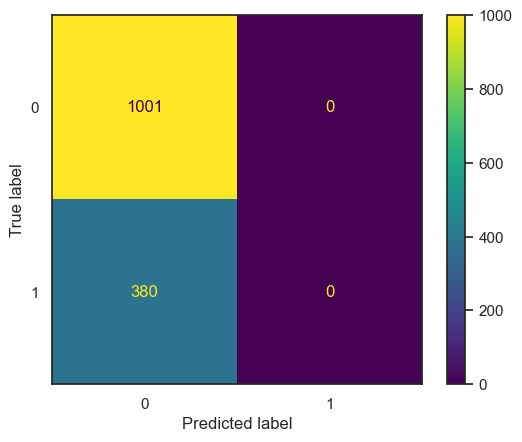

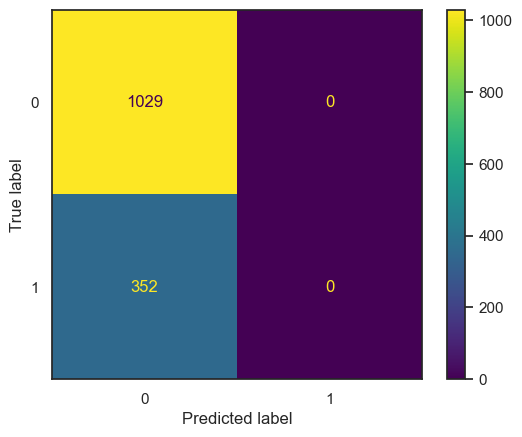

In [ ]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

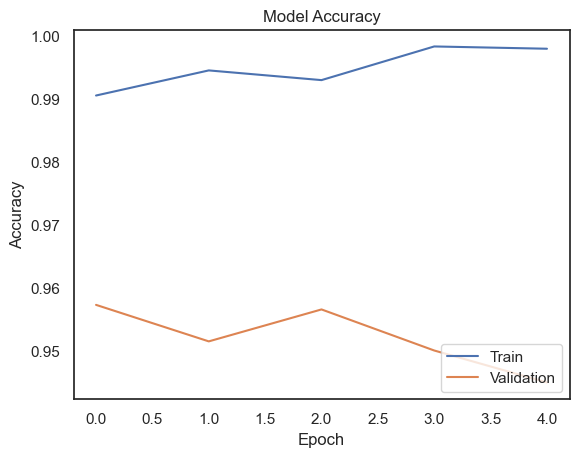

In [ ]:
# Summarize History for Accuracy

plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

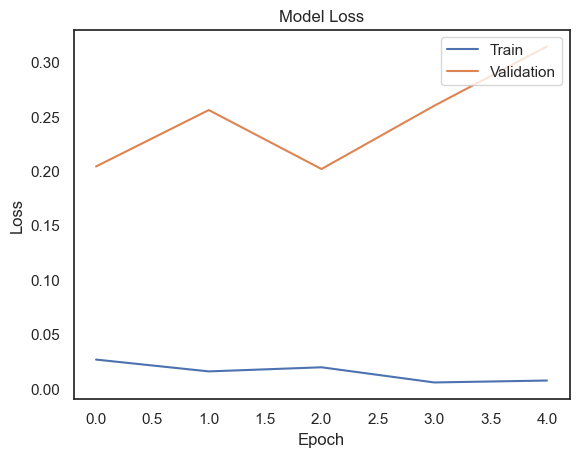

In [ ]:
# Summarize History for Loss

plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

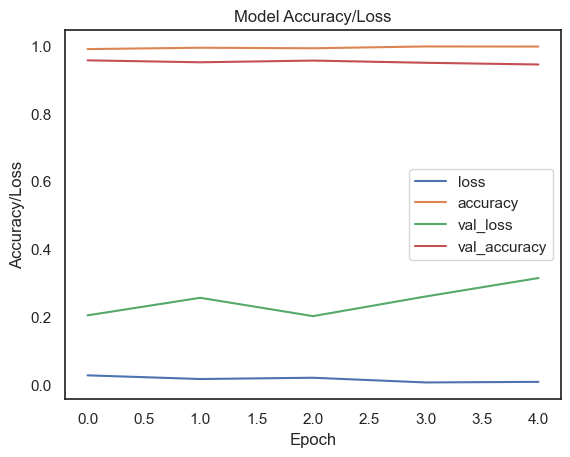

In [ ]:
# Accuracy Loss Graph

pd.DataFrame(cnn_model.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# We observe that Train & Validation Accuracy's Curve slightly overlap and same with Loss Curve.

# Hence, Overfitting is avoided, this is possible because of Dropout Regularization & Early Stopping Metrics